### Exploração Inicial dos Dados

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import dash_bootstrap_components as dbc
import warnings
warnings.filterwarnings('ignore')

#Carregando os dados
df = pd.read_csv('dados/amazon_delivery.csv')

#Visualização inicial
print("Primeiras linhas do dataset:")
display(df.head())

print("\nInformações sobre o dataset:")
display(df.info())

print("\nEstatísticas descritivas:")
display(df.describe())

print("\nValores faltantes por coluna:")
display(df.isnull().sum())

print("\nValores duplicados:", df.duplicated().sum())

Primeiras linhas do dataset:


,Order_ID,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Weather,Traffic,Vehicle,Area,Delivery_Time,Category
0,ialx566343618,37,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,motorcycle,Urban,120,Clothing
1,akqg208421122,34,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,scooter,Metropolitian,165,Electronics
2,njpu434582536,23,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,motorcycle,Urban,130,Sports
3,rjto796129700,38,4.7,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,Sunny,Medium,motorcycle,Metropolitian,105,Cosmetics
4,zguw716275638,32,4.6,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,Cloudy,High,scooter,Metropolitian,150,Toys



Informações sobre o dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43739 entries, 0 to 43738
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order_ID         43739 non-null  object 
 1   Agent_Age        43739 non-null  int64  
 2   Agent_Rating     43685 non-null  float64
 3   Store_Latitude   43739 non-null  float64
 4   Store_Longitude  43739 non-null  float64
 5   Drop_Latitude    43739 non-null  float64
 6   Drop_Longitude   43739 non-null  float64
 7   Order_Date       43739 non-null  object 
 8   Order_Time       43739 non-null  object 
 9   Pickup_Time      43739 non-null  object 
 10  Weather          43648 non-null  object 
 11  Traffic          43739 non-null  object 
 12  Vehicle          43739 non-null  object 
 13  Area             43739 non-null  object 
 14  Delivery_Time    43739 non-null  int64  
 15  Category         43739 non-null  object 
dtypes: float64(5), int64(2), obj

None


Estatísticas descritivas:


,Agent_Age,Agent_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Delivery_Time
count,43739.000000,43685.000000,43739.000000,43739.000000,43739.000000,43739.000000,43739.000000
mean,29.567137,4.633780,17.210960,70.661177,17.459031,70.821842,124.905645
std,5.815155,0.334716,7.764225,21.475005,7.342950,21.153148,51.915451
min,15.000000,1.000000,-30.902872,-88.366217,0.010000,0.010000,10.000000
25%,25.000000,4.500000,12.933298,73.170283,12.985996,73.280000,90.000000
50%,30.000000,4.700000,18.551440,75.898497,18.633626,76.002574,125.000000
75%,35.000000,4.900000,22.732225,78.045359,22.785049,78.104095,160.000000
max,50.000000,6.000000,30.914057,88.433452,31.054057,88.563452,270.000000



Valores faltantes por coluna:


Order_ID            0
Agent_Age           0
Agent_Rating       54
Store_Latitude      0
Store_Longitude     0
Drop_Latitude       0
Drop_Longitude      0
Order_Date          0
Order_Time          0
Pickup_Time         0
Weather            91
Traffic             0
Vehicle             0
Area                0
Delivery_Time       0
Category            0
dtype: int64


Valores duplicados: 0


### Limpeza e Preparação dos Dados

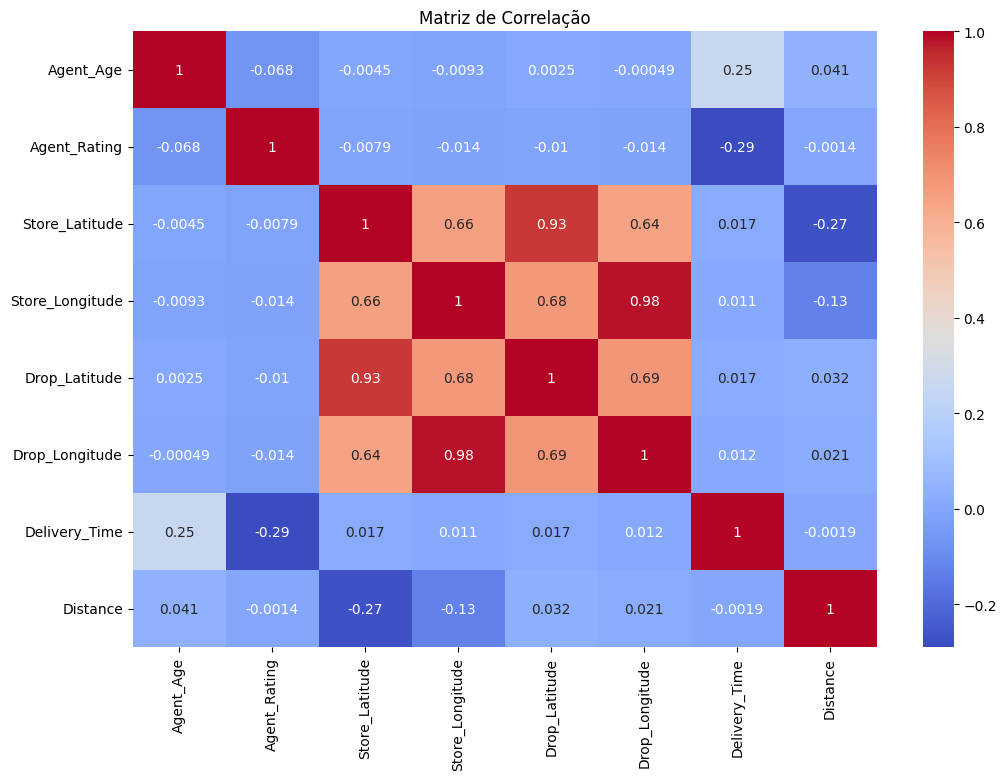

In [ ]:
#Tratamento de valores nulos
df['Agent_Rating'].fillna(df['Agent_Rating'].median(), inplace=True)

#Tratando valores NaN
df['Order_Time'] = pd.to_datetime(df['Order_Time'], errors='coerce')



#Criando as features de distância 
def haversine(lat1, lon1, lat2, lon2):
    # Fórmula simplificada para cálculo de distância
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    km = 6371 * c
    return km

df['Distance'] = df.apply(lambda x: haversine(x['Store_Latitude'], x['Store_Longitude'], 
                                             x['Drop_Latitude'], x['Drop_Longitude']), axis=1)


#Verificando as correlações
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## Análise Exploratória

### Distribuição do Tempo de Entrega

In [19]:
fig = px.histogram(df, x='Delivery_Time', nbins=50, 
                   title='Distribuição do Tempo de Entrega',
                   labels={'Delivery_Time': 'Tempo de Entrega (minutos)'})
fig.show()

### Tempo de Entrega por Tipo de Veículo

In [20]:
fig = px.box(df, x='Vehicle', y='Delivery_Time', 
             title='Tempo de Entrega por Tipo de Veículo',
             labels={'Vehicle': 'Tipo de Veículo', 'Delivery_Time': 'Tempo de Entrega (minutos)'})
fig.show()

### Impacto das Condições Climáticas

In [21]:
fig = px.box(df, x='Weather', y='Delivery_Time', 
             title='Impacto das Condições Climáticas no Tempo de Entrega',
             labels={'Weather': 'Condição Climática', 'Delivery_Time': 'Tempo de Entrega (minutos)'})
fig.show()

### Relação entre Distância e Tempo de Entrega

In [22]:
fig = px.scatter(df, x='Distance', y='Delivery_Time', 
                 trendline='ols',
                 title='Relação entre Distância e Tempo de Entrega',
                 labels={'Distance': 'Distância (km)', 'Delivery_Time': 'Tempo de Entrega (minutos)'})
fig.show()

### Tempo Médio de Entrega por Área

In [23]:
area_avg = df.groupby('Area')['Delivery_Time'].mean().reset_index()
fig = px.bar(area_avg, x='Area', y='Delivery_Time',
             title='Tempo Médio de Entrega por Área',
             labels={'Area': 'Área', 'Delivery_Time': 'Tempo Médio de Entrega (minutos)'})
fig.show()

## Modelagem Preditiva

### Preparação dos dados para modelagem

In [ ]:
#Codificando as variáveis categóricas
cat_cols = ['Weather', 'Traffic', 'Vehicle', 'Area', 'Category']
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])

#Selecionando as features e target
X = df.drop(['Order_ID', 'Order_Date', 'Order_Time', 'Pickup_Time', 'Delivery_Time'], axis=1)
y = df['Delivery_Time']

#Dividindo em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Normalizando os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Modelo de Regressão Linear

In [26]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred = lr.predict(X_test_scaled)

print("Desempenho da Regressão Linear:")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2_score(y_test, y_pred)}")

Desempenho da Regressão Linear:
MSE: 2076.906209915549
R²: 0.22036238223102522


### Modelo Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

print("\nDesempenho do Random Forest:")
print(f"MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"R²: {r2_score(y_test, y_pred_rf)}")

#Importância das features
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

fig = px.bar(feature_importance, x='Importance', y='Feature', 
             title='Importância das Features no Modelo Random Forest')
fig.show()


Desempenho do Random Forest:
MSE: 533.2402455949974
R²: 0.7998300776465339
